In [14]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [15]:
import time
from pathlib import Path
import glob
import os
import numpy as np
from tqdm import tqdm
import itertools
import csv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython.display as ipd
from IPython.display import clear_output
import math

import torch
import torchaudio
import soundfile as sf
from torchaudio.transforms import Vad

import wave
import librosa
import contextlib

import random
import shutil
from tqdm import tqdm
import subprocess
from pydub import AudioSegment
from scipy.io import wavfile

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="-", color='black')

In [17]:
from utils import *
from processing import *

## Audio utils

In [18]:
def plot_spec(filepath):
    samplingFrequency, signalData = wavfile.read(filepath)
    
    # Plot the signal read from wav file
    if len(signalData.shape) == 1:
        # single channel
        plt.figure(figsize=(12,8))
#         plt.grid(visible=True, axis='both')
        plt.subplot(211)

        plt.title('Spectrogram of a wav file')

        plt.plot(signalData)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.subplot(212)
        plt.specgram(signalData,Fs=samplingFrequency,NFFT=512)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
    else:
        signal_transpose = signalData.T
        for i, signal in enumerate(signal_transpose):
            print(f"Channel {i + 1}")
            plt.figure()
            plt.subplot(211)
            plt.title('Spectrogram of a wav file')

            plt.plot(signal.T)
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')

            plt.subplot(212)
            plt.specgram(signal.T,Fs=samplingFrequency,NFFT=512)
            plt.xlabel('Time')
            plt.ylabel('Frequency')

    plt.show()
    
def plot_duo(path1, path2):
    samplingFrequency1, signalData1 = wavfile.read(path1)
    samplingFrequency2, signalData2 = wavfile.read(path2)
    # single channel
#     plt.figure(figsize=(20,8))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4))
    axs[0, 0].plot(signalData1)
    axs[0, 0].set_title('Ref')
    axs[0, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[0, 1].specgram(signalData1,Fs=samplingFrequency1,NFFT=512)
    axs[0, 1].set(xlabel='Time', ylabel='Frequency')
    

    axs[1, 0].plot(signalData2)
    axs[1, 0].set_title('Com')
    axs[1, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[1, 1].specgram(signalData2,Fs=samplingFrequency2,NFFT=512)
    axs[1, 1].set(xlabel='Time', ylabel='Frequency')
    
    plt.tight_layout()
    plt.show()

def get_duration_file(fn_audio):
    with contextlib.closing(wave.open(str(fn_audio),'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration

def get_audio_overview(fn_audio):
    ob =  sf.SoundFile(fn_audio)
    return ob.subtype, ob.samplerate, ob.channels


def get_amplitute_file(path):
    sr, data = wavfile.read(path)
#     bit_depth = int(get_infor_file(path)[0].split('_')[-1])
    bit_depth = 16
    db = 20 * np.log10(max(abs(data))/(2**(bit_depth - 1) - 1))
    return sr, min(data), max(data), db

def get_duration_folder(folder):
    total_length = 0
    for audio in glob.glob(f"{folder}/*.wav"):
        try:
            total_length += get_duration_file(audio)
        except:
            print("error in ",audio)
    return total_length

def get_size_file(fname):
    return Path(fname).stat().st_size

def get_size_folder(folder):
    return sum([float(get_size_file(f)) for f in glob.glob(f"{folder}/*")])

def get_audio_stats(filename):
    cmd = ['ffmpeg', '-i', filename, '-map', '0:a', '-af', 'astats', '-f', 'null', '-']
#     cmd = ['ffprobe', filename]
    out = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE).stderr
    output_lines = [line.strip() for line in out.decode('utf-8').split('\n')]
    return output_lines


In [32]:
def stream_and_plot_audio(path, plot=False):
    audio = ipd.Audio(path, autoplay=True) 
    ipd.display(audio)
    if plot:
        plot_spec(path)

def stream_and_plot_in_class(folder, plot=False, delay=0.5, fmat='.wav'):
    audio_in_folder = glob.glob(f"{folder}/*{fmat}")
    for i, f in enumerate(audio_in_folder):
        path  = str(Path(f))
        print(f"[{i + 1}/{len(audio_in_folder)}] {path}", end=' ')

        stream_and_plot_audio(path, plot=plot)

        duration = librosa.get_duration(filename=path)

        time.sleep(duration + delay)
        
def stream_and_plot_in_root(root, plot=False, start_index=0):
    folders = Path(root).glob('*')
#     nfiles = [len(os.listdir(str(x))) for x in folders]
    
    for index, folder in enumerate(list(folders)[start_index:]):
        print('id:', index + start_index, folder.name)
        
        stream_and_plot_in_class(str(folder), plot=plot)
        time.sleep(1.0)
        clear_output(wait=True)
        
def compare2files(file1, file2, plot=False, stream=False):
    if plot:
        plot_duo(file1, file2)
        
    if stream:
        stream_and_plot_audio(file1, plot=False)
        duration = librosa.get_duration(filename=file1)
        time.sleep(duration + 0.5)

        stream_and_plot_audio(file2, plot=False)
        duration = librosa.get_duration(filename=file2)
        time.sleep(duration + 0.5)

In [33]:
import noisereduce as nr
# load data
def remove_noise(path):
    rate, data = wavfile.read(path)
    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate, n_fft=512, prop_decrease=0.99)
    filename = f"{path.replace('.wav', '')}_rm_noise.wav"
    wavfile.write(filename, rate, reduced_noise)
    return True

def change_volume(path=None, dB=6, overwrite=True):
    segment = AudioSegment.from_file(path)
    segment += dB
    if overwrite:
        path = path
    else:
        path = path.replace('.wav', '') + f'_{dB}' +'.wav'
    segment.export(path, format='wav')
    print(f'Export to {path}')

## Stream and visualize audio


#### File

In [34]:
path = f"log_service/audio_v2/346165056/346165056-20220310-173805_20220310_103846_com_0.wav"
stream_and_plot_audio(path, plot=True)
# !ffprobe "dataset/spoof/2835449000/2835449000_23_zoneB_rm_noise.wav"

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [35]:
com = f"log_service/audio/20220208_101958_com_vad_1.wav"

ref = f"log_service/audio/20220208_101947_ref_vad_0.wav"

compare2files(ref, com, plot=True, stream=True)

FileNotFoundError: [Errno 2] No such file or directory: 'log_service/audio/20220208_101947_ref_vad_0.wav'

#### Class

In [ ]:
with open("dataset/test_callbot_raw/infor.csv", 'w') as wf:
    for i, folder in enumerate(Path("dataset/test_callbot_raw/namdp5/").glob('*')):
#         wf.write(f"{i},{folder.name},{len(os.listdir(str(folder)))}\n")
        pass

In [ ]:
stream_and_plot_in_class("log_service/audio_v2/912582757/", plot=False)

#### Root

In [ ]:
stream_and_plot_in_root("dataset/test_callbot_raw/namdp5/", start_index=-2)

#### stats of audio

In [ ]:
!ffmpeg -i "dataset/test_callbot_raw/namdp5/349238241/349238241-20220204-101127-in_1.wav" -map 0:a -af astats -f null -

## Perform vad on long file(>10s of duration)

In [ ]:
path = f"log_service/audio/20220208_101947_ref.wav"
write = False
segments = vad_tool.VAD(win_length=300, frame_duration=30).detect(path, write=write, show=True)
print(len(segments))

# Visualize by graph dataset, plot graph

In [ ]:
origin = "dataset/train"
filenames = glob.glob(f"{origin}/*")

### number of files

In [ ]:
# so luong files moi nguoi
no_of_files = []
for f in tqdm(filenames):
    if len(os.listdir(f)) == 0:
        print(f)
    no_of_files.append(len(os.listdir(f)))
plt.figure(figsize=(24, 8))
plt.bar(filenames, no_of_files), plt.ylabel('number of files'), plt.xticks([])
plt.tight_layout()

In [ ]:
filenames[np.argmax(no_of_files)], filenames[np.argmin(no_of_files)], sum(no_of_files), max(no_of_files), min(no_of_files)

### Duration

In [ ]:
# duration
durations = []
for fn in tqdm(filenames):
    length = get_duration_folder(fn)
    durations.append(length)
plt.figure(figsize=(24, 8))
plt.bar(filenames, durations), plt.ylabel('durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
np.mean(durations), np.argmax(durations), sum(durations), max(durations), min(durations)

### average duration 

In [ ]:
# mat do thoi gian / 1 audio tren moi nguoi
import numpy as np
no_of_files = np.array(no_of_files)
durations = np.array(durations)
avg_durations = np.divide(durations, no_of_files)
plt.figure(figsize=(24, 8))
plt.bar(filenames, avg_durations), plt.ylabel('avg_durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
avg_durations.mean(), np.argmax(avg_durations), max(avg_durations), min(avg_durations)

In [ ]:
len(avg_durations[(avg_durations >= 1.5).nonzero()])

In [ ]:
#  index: 0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', 
#         4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', 
#         8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', 
#         12'Crest factor', 13'Flat factor', 14'Peak count',
#         15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', 
#         18'Zero crossings', 19'Zero crossings rate', 20'Error rate',

audio_full_infor = {}
detail_dir = Path('dataset/train_callbot/details/')
csv_s = detail_dir.glob('*.csv')

for f in tqdm(csv_s):
    audio_full_infor[f.name.replace('.csv', '')] = []
    
    with open(f, 'r', newline='') as rf:
        spamreader = csv.reader(rf, delimiter=',')
        next(spamreader, None)
        for row in spamreader:
            row_n = []
            for e in row:
                try:
                    row_n.append(float(e.strip()))
                except:
                    pass
            audio_full_infor[f.name.replace('.csv', '')].append(np.asanyarray(row_n))
            
    audio_full_infor[f.name.replace('.csv', '')] = np.asanyarray(audio_full_infor[f.name.replace('.csv', '')])
            
list(audio_full_infor.items())[:10]

index: <br/>
0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', <br/>
4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', <br/>
8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', <br/>
12'Crest factor', 13'Flat factor', 14'Peak count', <br/>
15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', <br/>
18'Zero crossings', 19'Zero crossings rate', 20'Error rate', <br/>

In [ ]:
# sum up informations
categories = ['Avg_duration', 'Min_duration', 'Max_duration', 
              'Avg_peakdB', 'Min_peakdB', 'Max_peakdB',
              'Avg_noisedB', 'Min_noisedB', 'Max_noisedB',
              '#valid files', '%valid']

# writefile = 'dataset/details_callbot.csv'
with open(writefile, 'w', newline='') as wf:
    spamwriter = csv.writer(wf, delimiter=',')
    spamwriter.writerow(categories)
    
    for k, v in tqdm(audio_full_infor.items()):
        avg_dur, min_dur, max_dur = np.mean(v[:,0]), min(v[:,0]), max(v[:,0])
        avg_db, min_db, max_db = np.mean(v[:,8]), min(v[:,8]), max(v[:,8])
        avg_noisedb, min_noisedb, max_noisedb =  np.mean(v[:,15]), min(v[:,15]), max(v[:,15])
        # error rate add here#
        f_invalid = read_blacklist(id=k,
                                 duration_limit=1.0, 
                                 dB_limit=-16, 
                                 error_limit=0, 
                                 noise_limit=-10, 
                                 details_dir="dataset/train_callbot/details/" )
        n_valid = len(v) - len(f_invalid) if f_invalid else len(v)
        p_valid = n_valid / len(v)
        
        row =  [avg_dur, min_dur, max_dur,
               avg_db, min_db, max_db,
               avg_noisedb, min_noisedb, max_noisedb,
               n_valid, p_valid]
#         spamwriter.writerow(row)

## Filtering DATASET

Check the inequality of dataset and print out details, return number of files greater ans lower than threshold(35 files)

In [ ]:
with open("Imposter_v2.txt", 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]

invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
# len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])

invalid_details = {}
for line in tqdm(lines):
    if ':' in line:
        k = ''.join(line.split(':')[1:]).strip()
        if k not in invalid_details:
            invalid_details[k] = {}
    elif '.wav' in line:
        fp = ''.join(line.split(' - ')[1:]).strip()
        n = line.split('-')[0].strip().replace('[', '').replace(']', '').split('/')
        rate = float(n[0])/float(n[1])
        
        k = list(invalid_details.keys())[-1]
        
        invalid_details[k][fp] = rate

list(invalid_details.items())[:10]
# invalid_cla                                                                                                                                     ss

### Train val generate simulation

In [98]:
from processing.dataset import read_blacklist, check_valid_audio
def generate_lists(raw_dataset, details_dir, num_spks, split_ratio,
                   duration_limit=1.0,
                   dB_limit=-10,
                   error_limit=0.5,
                   noise_limit=-16, 
                   lower_num=10, upper_num = 40,
                  gen_files=False):
    """
    Generate train test lists for zalo data
    """
    valid_spks = []
    invalid_spks = []
    
    root = Path(raw_dataset)
    classpaths = [d for d in root.iterdir() if d.is_dir()]
    classpaths.sort()
    
    if 0 < num_spks < len(classpaths) + 1:
        classpaths = classpaths[:num_spks]
    elif num_spks == -1:
        pass
    else:
        raise "Invalid number of speakers"

    print('Generate dataset metadata files, total:', len(classpaths))
    
    train_filepaths_list = []
    val_filepaths_list = []
            
    for classpath in tqdm(list(classpaths)[:], desc="Processing:..."):
        filepaths = list(classpath.glob('*.wav'))
        # filtering dataset
        ## check duration, volumn
        blist = read_blacklist(str(Path(classpath).name), 
                               duration_limit=duration_limit, 
                               dB_limit=dB_limit, 
                               error_limit=error_limit, 
                               noise_limit=noise_limit,
                               details_dir=details_dir)

        if blist is not None:
            filepaths = list(set(filepaths).difference(set(blist)))

        ## check duration, sr
        filepaths = check_valid_audio(filepaths, duration_limit, 8000)

        ## checknumber of files
        if lower_num:
            if len(filepaths) < lower_num:
                continue
                
        if upper_num > 0:
            if len(filepaths) >= upper_num:
                filepaths = filepaths[:upper_num]
                
        if len(filepaths) == 0:
            continue
                    
        valid_spks.append(Path(classpath).name)
        
        random.shuffle(filepaths)        
        
        # val
        val_num = 3  # 3 utterances per speaker for val

        if split_ratio > 0:
            val_num = int(split_ratio * len(filepaths))

        val_filepaths = random.sample(filepaths, val_num)
        
        train_filepaths = filepaths if split_ratio == -1 else list(set(filepaths) - set(val_filepaths))
        
        # write train file
        
        for train_filepath in train_filepaths:
            label = str(train_filepath.parent.stem.split('-')[0])
            train_filepaths_list.append(f"{label} {str(train_filepath)}\n")

        val_filepaths_list.append(val_filepaths)
                
    # gen val 
    val_pairs = []
    for val_filepaths in val_filepaths_list:
        for i in range(len(val_filepaths) - 1):
            for j in range(i + 1, len(val_filepaths)):
                label = '1'
                positive_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths[j]) + '\n'
                val_pairs.append(positive_pair)
    
                label = '0'
                while True:
                    x = random.randint(0, len(val_filepaths_list) - 1)
                    if not val_filepaths_list[x]:
                        continue
                    if val_filepaths_list[x][0].parent.stem != val_filepaths[i].parent.stem:
                        break
                        
                y = random.randint(0, len(val_filepaths_list[x]) - 1)
                negative_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths_list[x][y]) + '\n'
                val_pairs.append(negative_pair)
                
                
    if gen_files:
        with open(Path(root.parent, 'train_def_waug_shuffle.txt'), 'w') as wf:
            random.shuffle(train_filepaths_list) 
            wf.writelines(train_filepaths_list)
        with open(Path(root.parent, 'val_def_waug_shuffle.txt'), 'w') as wf:
            random.shuffle(val_pairs) 
            wf.writelines(val_pairs)        

    print("Valid speakers:", len(valid_spks))
    print("Valid audio files:", len(train_filepaths_list))
    print("Validation pairs:", len(val_pairs))

    return valid_spks, invalid_spks

In [239]:
valid_spks, invalid_spks = generate_lists(raw_dataset='dataset/train_callbot_v2/train_v2/', 
                                          details_dir='dataset/train_callbot_v2/details/', 
                                          num_spks=-1, split_ratio=-1, 
                                          duration_limit=3.0,
                                          dB_limit=-20,
                                          error_limit=0.5,
                                          noise_limit=-0,
                                          lower_num=3, upper_num = -1,
                                          gen_files = False)

Generate dataset metadata files, total: 16667


Processing:...: 100%|██████████| 16667/16667 [05:21<00:00, 51.87it/s]


Valid speakers: 11071
Valid audio files: 82045
Validation pairs: 66426


#### Write public and private test

In [130]:
source  = 'log_service/cskh_test_202203/ref_audio/'

import itertools    
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

folders = Path(source).glob('*/')
data = []
for folder in folders:
    f_lst = folder.glob('*.wav')

    data.extend([f"{folder.name} {path}" for path in f_lst])

pairs = all_pairs(data)
lines_truth = []
lines_test = []

for pair in pairs:
    label1 , path1 = pair[0].split(' ')
    label2 , path2 = pair[1].split(' ')
    lines_test.append(f"{path1},{path2}\n")
    lines_truth.append(f"{int(label1==label2)} {path1} {path2}\n")
    
with open(f'log_service/cskh_test_202203/ref_audio_truth.txt' , 'w') as wf:
    wf.writelines(lines_truth)
    
with open(Path(f'log_service/cskh_test_202203/ref_norm.txt'), 'w') as wf:
    wf.write(f"audio_1,audio_2\n")
    wf.writelines(lines_test)
print("Done")

Done


In [ ]:
with open("dataset/test_callbot/valid_speaker/private_test_cb_truth.txt", 'r') as rf:
    pairs = [x.replace('\n', '') for x in rf.readlines()]
len(pairs)

## Draft

generate test files from log audio

In [151]:
import itertools
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

    
list_test_ref = glob.glob(f'log_service/check_log_combine/ref/auth/*/*.wav')
list_test_com = glob.glob(f'log_service/check_log_combine/com/auth/*/*.wav')

list_test = list(set(list_test_ref + list_test_com))
print(len(list_test))

pairs = all_pairs(list_test)
print(len(pairs))

lines = []
lines_truth = []
counts_label = [0, 0]
for pair in tqdm(pairs):
    label1 = os.path.split(pair[0])[-1].split('.')[0].split('-')[0].replace('com_', '')
    label2 = os.path.split(pair[1])[-1].split('.')[0].split('-')[0].replace('com_', '')

    lines_truth.append(f"{int(label2==label1)} {pair[0]} {pair[1]}\n")    
    lines.append(f"{pair[0]},{pair[1]}\n")

    counts_label[0] += int(label2!=label1)
    counts_label[1] += int(label2==label1)

# with open(f'log_service/check_log_combine/ref_vs_com_auth_truth.txt' , 'w') as wf:
#     wf.writelines(lines_truth)
# with open(f'log_service/check_log_combine/ref_vs_com_auth.txt' , 'w') as wf:
#     wf.write("audio1,audio2\n")
#     wf.writelines(lines)

print('Done')
counts_label

459
105111


100%|██████████| 105111/105111 [00:00<00:00, 124638.16it/s]

Done


[99801, 5310]

#### Control volume of noise file

In [83]:
from pydub import AudioSegment
from processing.augment import *
for noise_f in tqdm(glob.glob("dataset/noise_vad/noise_vad/*/*.wav")):
    noise_seg = AudioSegment.from_file(noise_f)
    noise_seg_new_vol = gain_target_amplitude(noise_seg, -1)
    noise_seg_new_vol.export(noise_f, format="wav")

100%|██████████| 9015/9015 [00:04<00:00, 1932.65it/s]


#### Test augment with env_corrupt type

In [1]:
from utils import *
from processing import audio_loader
musan_path = "dataset/augment_data/musan_split"
rir_path = "dataset/augment_data/RIRS_NOISES/simulated_rirs"
augment_engine = audio_loader.AugmentWAV(musan_path=musan_path,
                                         rir_path=rir_path,
                                         max_frames=500,
                                         sample_rate=8000,target_db=None)
audio_file = "dataset/train_callbot_v2/train_v2/spk0/spk0-20220205-064325-in_0.wav"

40000 128924


rev None None


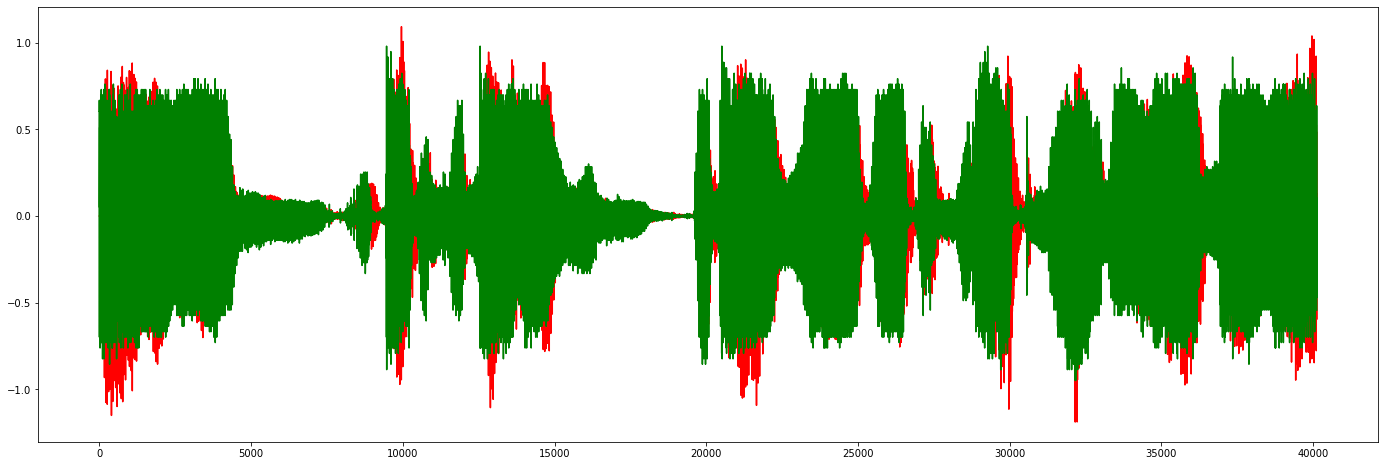

In [113]:
# %%timeit -n 100 -r 10
audio_file = "dataset/train_callbot_v2/train_v2/spk0/spk0-20220205-064325-in_0.wav"
audio = audio_loader.loadWAV(audio_file, 500, 
                evalmode=False, 
                augment=False, 
                sample_rate=8000, 
                augment_chain=[])
audio_raw = audio.copy()
augtype , mode, order = None, None, None
augtype = np.random.choice(['rev', 'noise', 'both', 'none'], p=[0.2, 0.6, 0, 0.2])


p_base = [0.25, 0.25, 0.25, 0.25]
if augtype == 'rev':
    audio = augment_engine.reverberate(audio)
elif augtype == 'noise':
    mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'],  p=p_base)
    audio = augment_engine.additive_noise(mode, audio)
elif augtype == 'both':
    # combined reverb and noise
    order = np.random.choice(['noise_first', 'rev_first'], p=[0.5, 0.5])
    if order == 'rev_first':
        audio =augment_engine.reverberate(audio)
        mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'],  p=p_base)
        audio = augment_engine.additive_noise(mode, audio)
    else:
        mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'],  p=p_base)
        audio = augment_engine.additive_noise(mode, audio)   
        audio = augment_engine.reverberate(audio)
else:
    # none type means dont augment
    pass
print(augtype , mode, order)

plt.figure(figsize=(24,8))
plt.plot(np.squeeze(audio), color='red')
plt.plot(np.squeeze(audio_raw), color='green')
plt.show()
ipd.Audio(audio, rate=8000, autoplay=True)

In [47]:
with open("label_for_log.csv","w+") as wf:
    wf.write("class,filename,label\n")
    for f in glob.glob("log_service/cskh_test_202203/wav_logs/*/*/*_norm.wav"):
        cls = f.split('/')[-2]
        wf.write(f"{cls}, {'/'.join(f.split('/')[-3:])}, 1\n")

In [162]:
stream_and_plot_in_class("log_service/check_log_combine/com/auth/346165056/", delay=1, fmat=".wav")

[1/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090434-2022-03-16-02-04-59.wav 

[2/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090434-2022-03-16-02-05-13.wav 

[3/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090434-2022-03-16-02-05-25.wav 

[4/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090434-2022-03-16-02-05-40.wav 

[5/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090611-2022-03-16-02-06-36.wav 

[6/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090812-2022-03-16-02-08-35.wav 

[7/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090812-2022-03-16-02-08-49.wav 

[8/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090812-2022-03-16-02-09-18.wav 

[9/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-090812-2022-03-16-02-09-32.wav 

[10/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-104417-2022-03-16-03-44-52.wav 

[11/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-104417-2022-03-16-03-45-06.wav 

[12/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-104417-2022-03-16-03-45-21.wav 

[13/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-105503-2022-03-16-03-56-07.wav 

[14/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-01-56.wav 

[15/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-02-10.wav 

[16/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-02-24.wav 

[17/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-02-37.wav 

[18/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-02-51.wav 

[19/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140133-2022-03-16-07-03-05.wav 

[20/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140600-2022-03-16-07-06-23.wav 

[21/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220316-140600-2022-03-16-07-06-37.wav 

[22/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-082400-2022-03-28-01-24-26.wav 

[23/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-082400-2022-03-28-01-24-42.wav 

[24/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091203-2022-03-28-02-12-28.wav 

[25/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091203-2022-03-28-02-12-46.wav 

[26/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091359-2022-03-28-02-14-18.wav 

[27/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091359-2022-03-28-02-15-01.wav 

[28/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091538-2022-03-28-02-16-01.wav 

[29/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091538-2022-03-28-02-16-42.wav 

[30/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091814-2022-03-28-02-18-51.wav 

[31/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091908-2022-03-28-02-19-31.wav 

[32/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-091908-2022-03-28-02-19-47.wav 

[33/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-134543-2022-03-28-06-46-07.wav 

[34/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-085906-2022-03-28-01-59-29.wav 

[35/35] log_service/check_log_combine/com/auth/346165056/346165056-346165056-20220328-085906-2022-03-28-01-59-58.wav 

In [147]:
# test set from log audios file
data_norm = {}
data_auth = {}
with open("log_service/label_for_log.csv", newline='') as rf:
        spamreader = csv.reader(rf, delimiter=',')
        next(spamreader, None)
        for row in spamreader:
            if row[0] not in data_norm:
                data_norm[row[0]] = []
            data_norm[row[0]].append([row[1].strip(), row[2]])
            
            if row[0] not in data_auth:
                data_auth[row[0]] = []
            data_auth[row[0]].append([row[1].strip().replace('_norm', ''), row[2]])
ref_auth = {}
ref_norm = {}
for spk in glob.glob("log_service/cskh_test_202203/ref_audio/*"):
    audio_fs = glob.glob(spk + '/*.wav')
    cls = spk.split('/')[-1]
    if cls not in ref_auth:
        ref_auth[cls] = []
    ref_auth[cls].extend(glob.glob(os.path.join(spk, '*.wav')))
for spk in glob.glob("log_service/cskh_test_202203/ref_audio_norm/*"):
    audio_fs = glob.glob(spk + '/*.wav')
    cls = spk.split('/')[-1]
    if cls not in ref_norm:
        ref_norm[cls] = []
    ref_norm[cls].extend(glob.glob(os.path.join(spk, '*.wav')))
data_norm 

{'988988883': [['wavs-2022-03-28/988988883/988988883-988988883-20220328-092401-2022-03-28-02-24-26_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-092401-2022-03-28-02-24-42_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-134705-2022-03-28-06-47-31_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-134705-2022-03-28-06-47-49_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-143845-2022-03-28-07-39-11_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-143845-2022-03-28-07-39-30_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-144009-2022-03-28-07-40-35_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-144009-2022-03-28-07-40-54_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988988883-988988883-20220328-144121-2022-03-28-07-41-46_norm.wav',
   '1'],
  ['wavs-2022-03-28/988988883/988

In [159]:
# create test file
# # log_service/cskh_test_202203/wav_logs/wavs-2022-03-30
for k, v in data_auth.items():
    os.makedirs(os.path.join(f"log_service/check_log_combine/com/auth/{k}"), exist_ok=True)
    for f, label in v:
        fullpath = os.path.join("log_service/cskh_test_202203/wav_logs/", f)
        if os.path.isfile(fullpath):
            if int(label) == 1:
                print(f"mv {fullpath} {fullpath.replace('/'.join(fullpath.split('/')[:4]), 'log_service/check_log_combine/com/auth')}")
#                 subprocess.call(f"mv {fullpath} {fullpath.replace('/'.join(fullpath.split('/')[:4]), 'log_service/check_log_combine/com/auth')}", shell=True)
            

for k, v in data_norm.items():
    os.makedirs(os.path.join(f"log_service/check_log_combine/com/norm/{k}"), exist_ok=True)
    for f, label in v:
        fullpath = os.path.join("log_service/cskh_test_202203/wav_logs/", f)
        if os.path.isfile(fullpath):
            if int(label) == 1:
                print(f"mv {fullpath} {fullpath.replace('/'.join(fullpath.split('/')[:4]), 'log_service/check_log_combine/com/norm')}")
#                 subprocess.call(f"mv {fullpath} {fullpath.replace('/'.join(fullpath.split('/')[:4]), 'log_service/check_log_combine/com/norm')}", shell=True)
    

100%|██████████| 1961764/1961764 [01:43<00:00, 18995.88it/s]


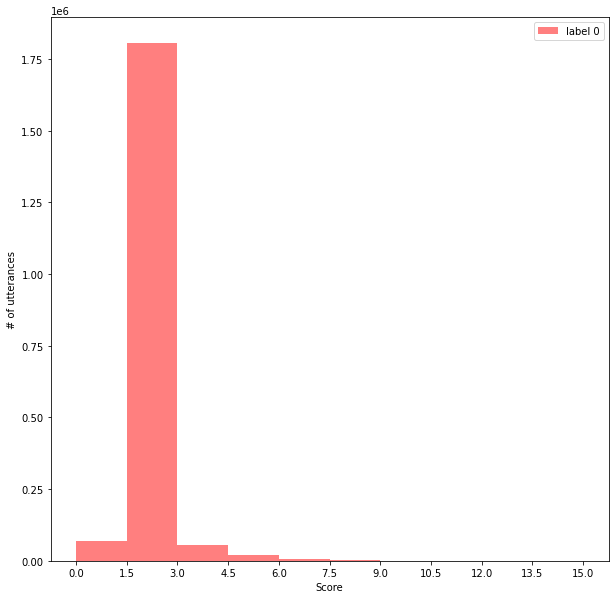

In [247]:
def plot_audio_distribution(root, dpi=10):
    audio_lst_path = glob.glob(root + '/*/*wav')
    durations = []
    for audio in tqdm(audio_lst_path):
        durations.append(get_duration_file(audio))
    
    bins = list(np.linspace(0.0, 15, num=dpi+1))
    
    plt.figure(figsize=(10,10))
    plt.xticks(np.linspace(0, 15, 11))
    plt.xlabel('Score'), plt.ylabel('# of utterances')
    
    plt.hist(durations, bins, alpha=0.5, histtype='stepfilled', color='r', label='label 0')  
    plt.legend(loc='upper right')
    plt.show()
plot_audio_distribution("dataset/train_callbot_v2/train_v2")

In [240]:
def plot_classification_performance(result_file, dpi=1000):
    lines = None
    with open(result_file, "r") as rf:
        lines = [line.replace('\n', '') for line in rf.readlines()]
    class_scores = [[x.split(',')[-3], x.split(',')[-1]]  for x in lines[1:]]
    
    class_0 = list(float(score) for _, score in filter(lambda x: True if x[0] == '0' else False, class_scores))
    print("Mean, deviation and variance of class 0:", np.mean(class_0), np.std(class_0), np.var(class_0))
    print("Min and max score of class 0:", np.min(class_0), np.max(class_0))
    class_1 = list(float(score) for _, score in filter(lambda x: True if x[0] == '1' else False, class_scores))
    print("Mean, deviation and variance of class 1:", np.mean(class_1), np.std(class_1), np.var(class_1))
    print("Min and max score of class 1:", np.min(class_1), np.max(class_1))    
    
    bins = list(np.linspace(0.0, 1.0, num=dpi+1))
    
    plt.figure(figsize=(10,10))
    plt.xticks(np.linspace(0, 1, 11))
    plt.xlabel('Score'), plt.ylabel('# of pairs')
    
    plt.hist(class_0, bins, alpha=0.5, histtype='stepfilled', color='r', label='label 0')
    plt.hist(class_1, bins, alpha=0.5, histtype='stepfilled', color='g', label='label 1')    
    plt.legend(loc='upper right')
    plt.show()


Mean, deviation and variance of class 0: 0.3067153264210863 0.1618101163457481 0.02618251375182454
Min and max score of class 0: 1.7599096e-09 0.9902159
Mean, deviation and variance of class 1: 0.4861840651131236 0.2520803977240211 0.06354452691670065
Min and max score of class 1: 2.6135098e-07 0.9999992


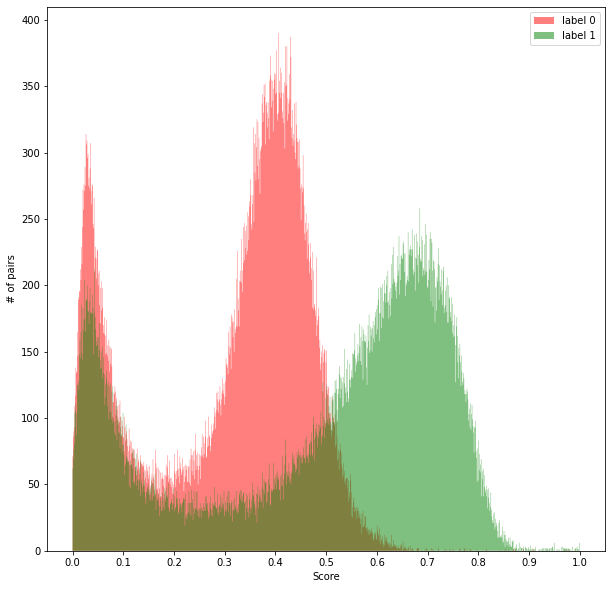

In [241]:
result_file = "backup/Raw_ECAPA_sinc/ARmSoftmax/result/evaluation_results.txt"
plot_classification_performance(result_file)

In [143]:
import pandas as pd
for rg in glob.glob("dataset/audio_labeling_sv_t4_1-master/BANGIAO/audio_labeling_sv_t4_1/*"):
    for csv_f in glob.glob(f"{rg}/*.csv"):     
        df = pd.read_csv(csv_f)
        print(csv_f,":\nis not ok:", 
              len(df['is_notok']), '\n', df['is_notok'].value_counts(), '\n\ngender:',
              len(df['gender']), '\n', df['gender'].value_counts(), '\n\nregions:',
              len(df['regions']), '\n', df['regions'].value_counts(), '\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\n')

dataset/audio_labeling_sv_t4_1-master/BANGIAO/audio_labeling_sv_t4_1/data_0h_100h_csv/data_cskh_1.csv :
is not ok: 24349 
 1.0    172
Name: is_notok, dtype: int64 

gender: 24349 
 1.0    14486
2.0     9691
Name: gender, dtype: int64 

regions: 24349 
 1.0    11480
3.0    10749
2.0     1948
Name: regions, dtype: int64 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

dataset/audio_labeling_sv_t4_1-master/BANGIAO/audio_labeling_sv_t4_1/data_0h_100h_csv/data_cskh_2.csv :
is not ok: 24988 
 1.0    833
Name: is_notok, dtype: int64 

gender: 24988 
 1.0    14075
2.0    10080
Name: gender, dtype: int64 

regions: 24988 
 1.0    12318
3.0     9783
2.0     2054
Name: regions, dtype: int64 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

dataset/audio_labeling_sv_t4_1-master/BANGIAO/audio_labeling_sv_t4_1/data_0h_100h_csv/data_cskh_3.csv :
is not ok: 24556 
 1.0    975
Name: is_notok, dtype: int64 

gender: 24556 
 1.0    13542
2.0    10039
Name: gender, dtype: int64 

regions: 24556 
 1.0    11198
3.0    10803
2.0     1

In [167]:
# 3 ref  + 1 test
# truth: label audio1 audio2
# test: audio1,audio2
com_dir = "log_service/check_log_combine/com/auth"
ref_dir = "log_service/check_log_combine/ref/auth"

test_pairs = []
test_pairs_truth = []

for com_id in glob.glob(com_dir + '/*'):
    com_audio_fs = glob.glob(com_id + '/*.wav')
    com_id_ = com_id.split('/')[-1]
    for com_audio_f in com_audio_fs:
        for ref_id in glob.glob(ref_dir + '/*'):
            ref_id_ = ref_id.split('/')[-1]
            ref_audio_fs = glob.glob(ref_id + '/*.wav')[:3]
            test_pairs.extend([f"{com_audio_f},{ref_audio_f}\n" for ref_audio_f in ref_audio_fs])
            test_pairs_truth.extend([f"{int(ref_id_ == com_id_)} {com_audio_f} {ref_audio_f}\n" for ref_audio_f in ref_audio_fs])

with open("log_service/check_log_combine/3ref1test.txt", "w+") as wf:
    wf.write("audio1,audio2\n")
    wf.writelines(test_pairs)
with open("log_service/check_log_combine/3ref1test_truth.txt", "w+") as wf:
    wf.writelines(test_pairs_truth)

In [170]:
# equitable set
audio_files = glob.glob(com_dir + '/*/*.wav') + glob.glob(ref_dir + '/*/*.wav')
print(len(audio_files))
audio_classes = {}
for audio_file in audio_files:
    label = audio_file.split('/')[-2]
    if label not in audio_classes:
        audio_classes[label] = []
    audio_classes[label].append(audio_file)
    
equitable_test_pairs = []
equitable_test_pairs_truth = []

for label, list_audio in audio_classes.items():
    # find audio in different classes
    diff_label_list_audio_files = []
    for diff_cls_lst in [value for key, value in audio_classes.items() if key != label]:
        diff_label_list_audio_files.extend(diff_cls_lst)
        
    for i in range(len(list_audio) - 1):
        for j in range(i + 1, len(list_audio)):
            # pos pair
            equitable_test_pairs.append(f"{str(list_audio[i])},{str(list_audio[j])}\n")
            equitable_test_pairs_truth.append(f"1 {str(list_audio[i])} {str(list_audio[j])}\n")
            # neg pair
            diff_label_list_audio_file = random.choice(diff_label_list_audio_files)
            equitable_test_pairs.append(f"{str(list_audio[i])},{str(diff_label_list_audio_file)}\n")
            equitable_test_pairs_truth.append(f"0 {str(list_audio[i])} {str(diff_label_list_audio_file)}\n")            
            
with open("log_service/check_log_combine/equitable_test.txt", "w+") as wf:
    wf.write("audio1,audio2\n")
    wf.writelines(equitable_test_pairs)
with open("log_service/check_log_combine/equitable_test_truth.txt", "w+") as wf:
    wf.writelines(equitable_test_pairs_truth)


459


In [168]:
audio_files = glob.glob(com_dir + '/*/*.wav') + glob.glob(ref_dir + '/*/*.wav')
all_audio_pairs = all_pairs(audio_files)

all_test = []
all_test_truth = []

for pair in pairs:
    label1 = pair[0].split('/')[-2]
    label2 = pair[1].split('/')[-2]
    all_test.append(f"{pair[0]},{pair[1]}")
    all_test_truth.append(f"{int(label1 == label2)} {pair[0]} {pair[1]}")
    
with open("log_service/check_log_combine/all_test.txt", "w+") as wf:
    wf.write("audio1,audio2\n")
    wf.writelines(all_test)
with open("log_service/check_log_combine/all_test_truth.txt", "w+") as wf:
    wf.writelines(all_test_truth)

    

In [234]:
import torchaudio
from nnAudio import features
trans1 = torchaudio.transforms.MFCC(n_mfcc= 80, 
                                    sample_rate=8000, 
                                    melkwargs={"n_fft": 512, 
                                               "hop_length": 80, 
                                               "win_length" :200,
                                               'f_min':10, 'f_max':4000, 
                                               'window_fn': torch.hamming_window, 
                                               "power": 2, 
                                               'n_mels':80,
                                               'norm':'slaney',
                                               'mel_scale': 'slaney'})


trans2 = features.mel.MFCC(sr=8000, 
                                   n_fft=512, 
                                   win_length=200, 
                                   n_mfcc=80,
                                   n_mels=80,
                                   hop_length=80, 
                                   window='hamming', 
                                   fmin=10.0, fmax=4000, 
                                   trainable_mel=False, 
                                   trainable_STFT=False,
                                   verbose=False)

from processing.audio_loader import loadWAV
audio_file = "log_service/audio_thudth1/audio_thudth1/ref_audio/988988883/988988883-2022-03-24-10-31-23.wav"
audio  = np.array(loadWAV(audio_file, 200, evalmode=False), dtype=np.float16)

audio_tensor = torch.FloatTensor(audio)
out1 = trans1(audio_tensor).detach().cpu().numpy()
out2 = trans2(audio_tensor).detach().cpu().numpy()

In [235]:
print(out1.shape, out2.shape)
# np.allclose(out1, out2, rtol=1e-05, atol=1e-08, equal_nan=False)
np.testing.assert_allclose(out1, out2, rtol=1e-03, atol=1e-05)

(1, 80, 202) (1, 80, 202)


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 508 / 16160 (3.14%)
Max absolute difference: 0.00088382
Max relative difference: 0.21534169
 x: array([[[-4.327014e+02, -4.034877e+02, -4.276007e+02, ...,
         -5.645989e+02, -5.781017e+02, -5.900827e+02],
        [-3.834522e+00, -6.207274e-01, -1.566207e+00, ...,...
 y: array([[[-4.327014e+02, -4.034877e+02, -4.276007e+02, ...,
         -5.645988e+02, -5.781017e+02, -5.900826e+02],
        [-3.834591e+00, -6.207401e-01, -1.566262e+00, ...,...

In [252]:
count = 0
list_files = []
for file in tqdm(glob.glob("dataset/train_callbot_v2/train_v2/*")):
    if len(os.listdir(file)) == 0:
        list_files.append(file)
for file in tqdm(list_files):
    if len(glob.glob(file + '/*.wav')) == 0:
        subprocess.call(f"rm -r {file}", shell=True)

100%|██████████| 603/603 [00:57<00:00, 10.43it/s]
